In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Train Data
df = pd.read_csv('data/train.csv')
X = df.drop('label', axis=1) # Features
y = df['label']              # Labels

X = X.astype('float32') / 255.0 # normalize
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values)
X = X.reshape(-1, 1, 28, 28)

print(X.shape)
print(y.shape)

torch.Size([42000, 1, 28, 28])
torch.Size([42000])


torch.Size([10, 1, 28, 28])
torch.Size([10])


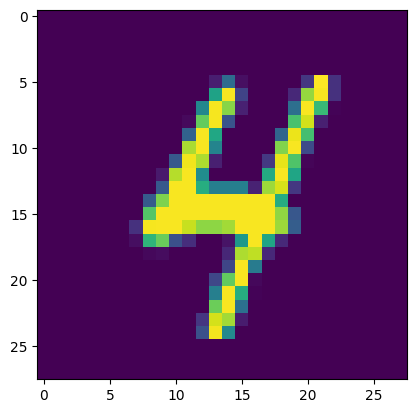

In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X[:38000], y[:38000])
test_dataset  = CustomDataset(X[38000:], y[38000:])
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True) # TODO: try bigger batch
test_loader  = DataLoader(test_dataset,  batch_size=10, shuffle=False)

# Test how it works :)
for X_train, y_train in train_loader:
    break
print(X_train.shape)
print(y_train.shape)
plt.imshow(X_train[0][0])

In [5]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        # in: 28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3) # out: 6*26*26
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # out: 6*13*13
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) # out: 16*11*11
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # out: 16*5*5
        # Fully connected
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*5*5) # -1 means any batch size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = AdvancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

AdvancedCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
model_weights = []

epochs = 30 # too big number on purpose, want to detect an overfit
for i in range(epochs):
    # Train
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for X_train, y_train in tqdm(train_loader, desc=f'Epoch {i}/{epochs} (Training)'):
        optimizer.zero_grad()
        # Forward
        y_predicted = model(X_train)
        loss = criterion(y_predicted, y_train)
        _, predicted = torch.max(y_predicted, 1)
        total += y_train.size(0)
        correct += (predicted == y_train).sum()
        running_loss += loss
        # Update parameters
        loss.backward()
        optimizer.step()
    # Training accuracy
    train_accuracy.append(correct / total)
    # Average training loss
    avg_loss = running_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f'Epoch {i}/{epochs} (Training) Correct {correct}/{total} Loss {avg_loss}')
    weights = model.state_dict()
    model_weights.append(weights)
    torch.save(weights, f'weights/model_weights_epoch_{i}.pt')

    # Test
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader, desc=f'Epoch {i}/{epochs} (Validation)'):
            y_validation = model(X_test)
            _, predicted = torch.max(y_validation, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum()
            # Compute testing loss
            loss = criterion(y_validation, y_test)
            running_loss += loss
    # Testing accuracy
    test_accuracy.append(correct / total)
    # Average testing loss
    avg_loss = running_loss / len(test_loader)
    test_loss.append(avg_loss)
    print(f'Epoch {i}/{epochs} (Validation) Correct {correct}/{total} Loss {avg_loss}')

Epoch 0/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 348.55it/s]


Epoch 0/30 (Training) Correct 35406/38000 Loss 0.2110530585050583


Epoch 0/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1351.83it/s]


Epoch 0/30 (Validation) Correct 3895/4000 Loss 0.0924813374876976


Epoch 1/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 374.16it/s]


Epoch 1/30 (Training) Correct 37107/38000 Loss 0.0778055340051651


Epoch 1/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1581.32it/s]


Epoch 1/30 (Validation) Correct 3902/4000 Loss 0.07566492259502411


Epoch 2/30 (Training): 100%|██████████| 3800/3800 [00:09<00:00, 383.07it/s]


Epoch 2/30 (Training) Correct 37308/38000 Loss 0.055514559149742126


Epoch 2/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1078.87it/s]


Epoch 2/30 (Validation) Correct 3912/4000 Loss 0.07051663100719452


Epoch 3/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 374.06it/s]


Epoch 3/30 (Training) Correct 37486/38000 Loss 0.0429203063249588


Epoch 3/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1474.49it/s]


Epoch 3/30 (Validation) Correct 3942/4000 Loss 0.053281381726264954


Epoch 4/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 370.55it/s]


Epoch 4/30 (Training) Correct 37598/38000 Loss 0.03362326696515083


Epoch 4/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1395.82it/s]


Epoch 4/30 (Validation) Correct 3923/4000 Loss 0.07537972182035446


Epoch 5/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 362.93it/s]


Epoch 5/30 (Training) Correct 37650/38000 Loss 0.028536854311823845


Epoch 5/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1381.21it/s]


Epoch 5/30 (Validation) Correct 3928/4000 Loss 0.05811386927962303


Epoch 6/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 375.30it/s]


Epoch 6/30 (Training) Correct 37715/38000 Loss 0.02336837165057659


Epoch 6/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1388.18it/s]


Epoch 6/30 (Validation) Correct 3940/4000 Loss 0.05766093730926514


Epoch 7/30 (Training): 100%|██████████| 3800/3800 [00:09<00:00, 385.87it/s]


Epoch 7/30 (Training) Correct 37745/38000 Loss 0.02139112912118435


Epoch 7/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1290.30it/s]


Epoch 7/30 (Validation) Correct 3936/4000 Loss 0.0679163932800293


Epoch 8/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 366.89it/s]


Epoch 8/30 (Training) Correct 37776/38000 Loss 0.016870424151420593


Epoch 8/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1349.17it/s]


Epoch 8/30 (Validation) Correct 3952/4000 Loss 0.05445730686187744


Epoch 9/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 367.27it/s]


Epoch 9/30 (Training) Correct 37809/38000 Loss 0.01557890698313713


Epoch 9/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1090.59it/s]


Epoch 9/30 (Validation) Correct 3931/4000 Loss 0.07139001041650772


Epoch 10/30 (Training): 100%|██████████| 3800/3800 [00:09<00:00, 380.14it/s]


Epoch 10/30 (Training) Correct 37830/38000 Loss 0.014548107981681824


Epoch 10/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1350.50it/s]


Epoch 10/30 (Validation) Correct 3952/4000 Loss 0.06593596935272217


Epoch 11/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 363.06it/s]


Epoch 11/30 (Training) Correct 37861/38000 Loss 0.012515167705714703


Epoch 11/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1398.88it/s]


Epoch 11/30 (Validation) Correct 3951/4000 Loss 0.07356409728527069


Epoch 12/30 (Training): 100%|██████████| 3800/3800 [00:11<00:00, 335.79it/s]


Epoch 12/30 (Training) Correct 37870/38000 Loss 0.01101489458233118


Epoch 12/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1385.60it/s]


Epoch 12/30 (Validation) Correct 3942/4000 Loss 0.08093581348657608


Epoch 13/30 (Training): 100%|██████████| 3800/3800 [00:11<00:00, 343.49it/s]


Epoch 13/30 (Training) Correct 37860/38000 Loss 0.011343702673912048


Epoch 13/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1254.62it/s]


Epoch 13/30 (Validation) Correct 3944/4000 Loss 0.08925989270210266


Epoch 14/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 353.98it/s]


Epoch 14/30 (Training) Correct 37867/38000 Loss 0.012086479924619198


Epoch 14/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1320.71it/s]


Epoch 14/30 (Validation) Correct 3935/4000 Loss 0.1082751452922821


Epoch 15/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 357.01it/s]


Epoch 15/30 (Training) Correct 37856/38000 Loss 0.011376073583960533


Epoch 15/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1402.21it/s]


Epoch 15/30 (Validation) Correct 3944/4000 Loss 0.0754672959446907


Epoch 16/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 346.83it/s]


Epoch 16/30 (Training) Correct 37899/38000 Loss 0.008221120573580265


Epoch 16/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1333.83it/s]


Epoch 16/30 (Validation) Correct 3944/4000 Loss 0.08005504310131073


Epoch 17/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 347.07it/s]


Epoch 17/30 (Training) Correct 37900/38000 Loss 0.008827420882880688


Epoch 17/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1193.18it/s]


Epoch 17/30 (Validation) Correct 3948/4000 Loss 0.06910581886768341


Epoch 18/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 346.37it/s]


Epoch 18/30 (Training) Correct 37899/38000 Loss 0.00947111751884222


Epoch 18/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1407.06it/s]


Epoch 18/30 (Validation) Correct 3931/4000 Loss 0.10608324408531189


Epoch 19/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 363.73it/s]


Epoch 19/30 (Training) Correct 37904/38000 Loss 0.010218861512839794


Epoch 19/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1339.75it/s]


Epoch 19/30 (Validation) Correct 3940/4000 Loss 0.08262065052986145


Epoch 20/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 366.32it/s]


Epoch 20/30 (Training) Correct 37935/38000 Loss 0.005983514711260796


Epoch 20/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1355.67it/s]


Epoch 20/30 (Validation) Correct 3959/4000 Loss 0.07981431484222412


Epoch 21/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 347.60it/s]


Epoch 21/30 (Training) Correct 37922/38000 Loss 0.00887332484126091


Epoch 21/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1446.68it/s]


Epoch 21/30 (Validation) Correct 3943/4000 Loss 0.0914345532655716


Epoch 22/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 366.53it/s]


Epoch 22/30 (Training) Correct 37932/38000 Loss 0.007238280493766069


Epoch 22/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1355.12it/s]


Epoch 22/30 (Validation) Correct 3925/4000 Loss 0.12156244367361069


Epoch 23/30 (Training): 100%|██████████| 3800/3800 [00:11<00:00, 344.10it/s]


Epoch 23/30 (Training) Correct 37904/38000 Loss 0.007458974607288837


Epoch 23/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1361.73it/s]


Epoch 23/30 (Validation) Correct 3942/4000 Loss 0.11440082639455795


Epoch 24/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 345.93it/s]


Epoch 24/30 (Training) Correct 37900/38000 Loss 0.008790915831923485


Epoch 24/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1333.39it/s]


Epoch 24/30 (Validation) Correct 3939/4000 Loss 0.13104066252708435


Epoch 25/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 356.33it/s]


Epoch 25/30 (Training) Correct 37922/38000 Loss 0.006142422091215849


Epoch 25/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1525.08it/s]


Epoch 25/30 (Validation) Correct 3922/4000 Loss 0.17391952872276306


Epoch 26/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 360.64it/s]


Epoch 26/30 (Training) Correct 37922/38000 Loss 0.008309144526720047


Epoch 26/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1352.18it/s]


Epoch 26/30 (Validation) Correct 3947/4000 Loss 0.10943743586540222


Epoch 27/30 (Training): 100%|██████████| 3800/3800 [00:11<00:00, 340.11it/s]


Epoch 27/30 (Training) Correct 37917/38000 Loss 0.007148085627704859


Epoch 27/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1516.14it/s]


Epoch 27/30 (Validation) Correct 3945/4000 Loss 0.13089662790298462


Epoch 28/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 348.42it/s]


Epoch 28/30 (Training) Correct 37939/38000 Loss 0.00627135718241334


Epoch 28/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1199.31it/s]


Epoch 28/30 (Validation) Correct 3951/4000 Loss 0.10730435699224472


Epoch 29/30 (Training): 100%|██████████| 3800/3800 [00:10<00:00, 356.41it/s]


Epoch 29/30 (Training) Correct 37939/38000 Loss 0.00788129586726427


Epoch 29/30 (Validation): 100%|██████████| 400/400 [00:00<00:00, 1379.27it/s]

Epoch 29/30 (Validation) Correct 3939/4000 Loss 0.1479770690202713


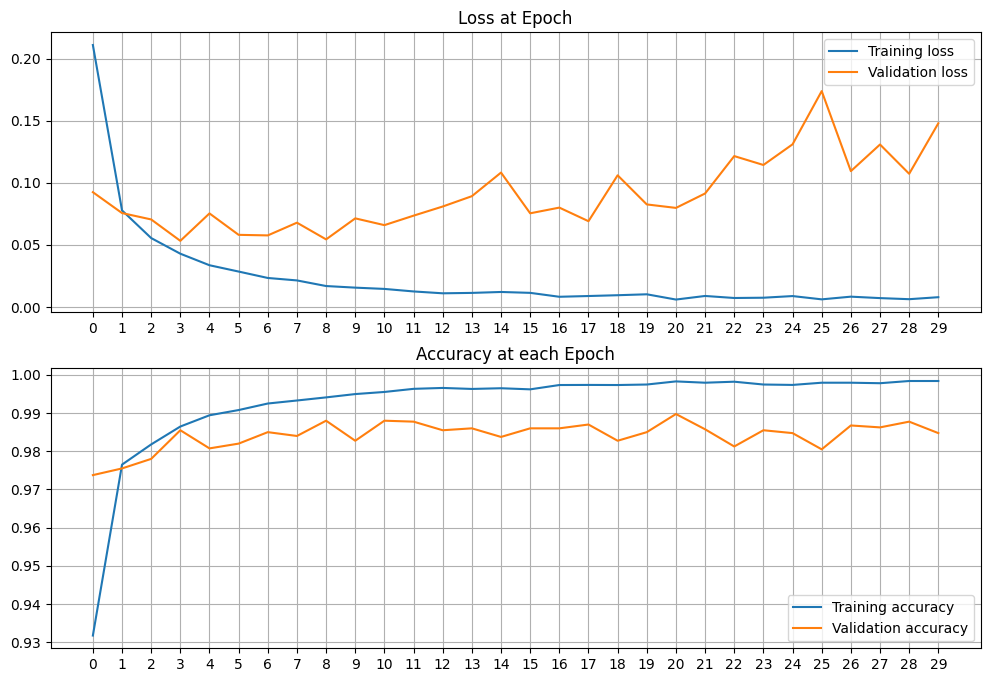

In [60]:
f, axarr = plt.subplots(2, 1, figsize=(12, 8))
axarr[0].plot([tl.item() for tl in train_loss], label='Training loss')
axarr[0].plot([tl.item() for tl in test_loss], label='Validation loss')
axarr[0].set_title('Loss at each Epoch')
axarr[0].set_xticks(range(len(train_loss)))
axarr[0].grid()
axarr[0].legend()
axarr[1].plot(train_accuracy, label='Training accuracy')
axarr[1].plot(test_accuracy,  label='Validation accuracy')
axarr[1].set_title('Accuracy at each Epoch')
axarr[1].set_xticks(range(len(test_loss)))
axarr[1].grid()
axarr[1].legend()

In [61]:
# Epoch 8: smallest loss, good validation accuracy
# Epoch 20: highest validation accuracy

In [41]:
# Submission Data
X = pd.read_csv('data/test.csv')
X = X.astype('float32') / 255.0 # normalize
X = torch.tensor(X.values, dtype=torch.float32)
X = X.reshape(-1, 1, 28, 28)
submission_loader = DataLoader(X, batch_size=32, shuffle=False)
print(X.shape)

torch.Size([28000, 1, 28, 28])


In [42]:
# Epoch 8
model.load_state_dict(model_weights[8])
model.eval()

predicted_labels = []
with torch.no_grad():
    for inputs in submission_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())

output_data = pd.DataFrame({'Label': predicted_labels})
output_data.index += 1
output_data.index.names = ['ImageId']
output_data.to_csv('submission.csv')
output_data

,Label
ImageId,
1,2
2,0
3,9
4,8
5,3
...,...
27996,9
27997,7
27998,3


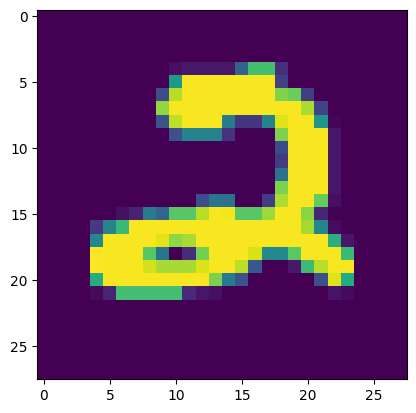

In [40]:
# Looks correct
plt.imshow(X[0][0])